In [47]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import sys
import time

from model import Model
from dataset import WheatAwnDataset

import PIL
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

%matplotlib inline

In [3]:
def plot_training_history(history_dict_pkl_path):
    '''helper function to take a history dictionary pickel file and plot it
    
    history dict structure:
    
                 h_d = {'date': current_time,
                        'epochs': epoch+1,
                        'training_loss_history':training_loss_history,
                        'training_accuracy_history':training_accuracy_history,
                        'validation_loss_history':validation_loss_history,
                        'validation_accuracy_history':validation_accuracy_history,
                        'exposure_training_loss_history': exposure_training_loss_history,
                        'exposure_training_accuracy_history': exposure_training_accuracy_history,
                        'exposure_validation_loss_history': exposure_validation_loss_history,
                        'exposure_validation_accuracy_history': exposure_validation_accuracy_history}
    
    '''
    
    with open(history_dict_pkl_path, 'rb') as f:
        history_dict = pickle.load(f)
    

                            
                            
    fig = plt.figure(figsize=(20,8))

    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Training/Validation Loss across Epochs")
    plt.scatter([-0.1], history_dict['exposure_training_loss_history'], c='darkblue', marker="P", label='EXP-train-loss')
    plt.scatter([-0.1], history_dict['exposure_validation_loss_history'], c='orangered', marker="X", label= 'EXP-val-loss')
    plt.plot(range(history_dict['epochs']), history_dict['training_loss_history'], label='train-loss')
    plt.plot(range(history_dict['epochs']), history_dict['validation_loss_history'], label= 'validation-loss')
    
    plt.ylabel('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("Training/Validation Accuracy across Epochs")
    plt.scatter([-0.1], history_dict['exposure_training_accuracy_history'],c='darkblue', marker="P", label='EXP-train-accuracy')
    plt.scatter([-0.1], history_dict['exposure_validation_accuracy_history'], c='orangered', marker="X", label= 'EXP-val-accuracy')
    plt.plot(range(history_dict['epochs']), history_dict['training_accuracy_history'], label='train-accuracy')
    plt.plot(range(history_dict['epochs']), history_dict['validation_accuracy_history'], label= 'validation-accuracy')
    plt.ylabel('Training/Validation accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    
    fig.suptitle(f"Training Run Loss/Accuracy History {history_dict_pkl_path.split('/')[-1].split('training')[0]}")
    
    plt.show()

In [33]:
def get_confusion_matrix_for_dataset(data_csv, batch_size, saved_model, title):
    '''
    helper function to wrap up generating a dataloader, collecting
    predictions, and plotting a confusion matrix for a specific dataset
    '''
    
    #collect test dataset and create loader iterable-object
    dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
    
    transform = transforms.Compose([transforms.CenterCrop((224,224)), transforms.ToTensor()])

    data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    #track the correct predictions
    corrects = 0.0

    #set model mode
    saved_model.eval()

    # Get the predictions/GT's for the confusion matrix
    predictions = []
    ground_truths = []

    #make sure to not accumulate gradients
    with torch.no_grad():

        progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

        for step, data in enumerate(progress_bar):

            #unpack the data from the progress bar
            images, labels = data[0], data[1]

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            #images = images.float() #uncomment if using read_image() from torch
            outputs = saved_model(images)

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions
            corrects += torch.sum(preds == labels.data).item()

            ground_truths.extend(list(labels.cpu().numpy()))
            predictions.extend(list(preds.cpu().numpy()))
            
    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100
    accuracy = "{:5.2f}".format(accuracy)
    print("accuracy: ", accuracy)
    print('\n')
    print("predictions:   ", len(predictions))
    print("ground truths: ", len(ground_truths))
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)
    
    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(title, fontsize=18)
    plt.show()

### This Notebook will be used to Evaluate Trained Models on Testing Data
-both 2020 and 2019 testing data will be used<br/>-we will also use it to visualize model performance<br/>-we can also directly compare variout trained models<br/>-each evaluation block will start with a markdown cell containing the **"path/to/the/model's/state_dtict.pth"** file as well as the hyper parmeters used

In [5]:
#sort image files (accuracy vs loss plots)
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
plot_files = filter(os.path.isfile, os.listdir(search_dir))
plot_files = [os.path.join(search_dir, f) for f in plot_files]# add path to each file

plot_files = [file for file in plot_files if file.endswith('.jpg')]
plot_files.sort(key=lambda x: os.path.getmtime(x))

for file in plot_files:
    print(f"file: {file.split('/')[-1]}\n time: {datetime.fromtimestamp(os.path.getmtime(file))}\n")

file: test_loss_accuracy-plot.jpg
 time: 2021-10-17 14:56:08.634031

file: 2021-10-17-15_24_58_loss_accuracy-plot.jpg
 time: 2021-10-17 15:24:58.844047

file: 2021-10-17-15_27_56_loss_accuracy-plot.jpg
 time: 2021-10-17 15:27:56.908515

file: 2021-10-17-16_03_58_loss_accuracy-plot.jpg
 time: 2021-10-17 16:03:58.574784

file: 2021-10-19-12_20_00_loss_accuracy-plot.jpg
 time: 2021-10-19 12:23:38.676288

file: 2021-10-19-12_43_19_loss_accuracy-plot.jpg
 time: 2021-10-19 12:43:48.781290

file: 2021-10-19-12_45_24_loss_accuracy-plot.jpg
 time: 2021-10-19 12:45:53.247819

file: 2021-10-19-12_47_53_loss_accuracy-plot.jpg
 time: 2021-10-19 12:48:22.072233

file: 2021-10-19-12_49_28_loss_accuracy-plot.jpg
 time: 2021-10-19 12:49:58.360736

file: 2021-10-19-13_01_59_loss_accuracy-plot.jpg
 time: 2021-10-19 13:02:28.148023

file: 2021-10-19-13_04_30_loss_accuracy-plot.jpg
 time: 2021-10-19 13:04:53.676319

file: 2021-10-19-13_05_34_loss_accuracy-plot.jpg
 time: 2021-10-19 13:06:02.199813

file: 2

In [6]:
#sort state_dict (.pth) files in runs dir
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
pth_files = filter(os.path.isfile, os.listdir(search_dir))
pth_files = [os.path.join(search_dir, f) for f in pth_files]# add path to each file

pth_files = [file for file in pth_files if file.endswith('.pth')] #only get model files
pth_files.sort(key=lambda x: os.path.getmtime(x))

for file in pth_files:
    print(f"file: {file.split('/')[-1]}\n time: {datetime.fromtimestamp(os.path.getmtime(file))}\n")

file: 2021-10-20-06_44_27_model_epoch-5.pth
 time: 2021-10-20 16:22:36.356746

file: 2021-10-20-06_44_27_model_epoch-9.pth
 time: 2021-10-20 20:45:13.169098

file: 2021-10-21-17_52_20_model_epoch-5.pth
 time: 2021-10-22 08:07:32.663433

file: 2021-10-21-17_52_20_model_epoch-9.pth
 time: 2021-10-23 00:20:33.535833

file: 2021-10-23-16_47_15_model_epoch-2_val-acc-90.148.pth
 time: 2021-10-23 22:48:31.256144

file: 2021-10-23-16_47_15_model_epoch-3_val-acc-90.161.pth
 time: 2021-10-24 00:52:14.608295

file: 2021-10-23-16_47_15_model_epoch-4_val-acc-90.352.pth
 time: 2021-10-24 02:55:27.114152

file: 2021-10-23-16_47_15_model_epoch-5_val-acc-90.269.pth
 time: 2021-10-24 04:58:57.548441

file: 2021-10-23-16_47_15_model_epoch-6_val-acc-89.732.pth
 time: 2021-10-24 07:02:16.912346

file: 2021-10-24-19_00_27_model_epoch-1_val-acc-90.599.pth
 time: 2021-10-24 23:58:38.276517

file: 2021-10-24-19_00_27_model_epoch-2_val-acc-90.186.pth
 time: 2021-10-25 04:11:39.851007

file: 2021-10-24-19_00_27_

In [7]:
#sort training history (.pkl) pickel files
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
pkl_files = filter(os.path.isfile, os.listdir(search_dir))
pkl_files = [os.path.join(search_dir, f) for f in pkl_files]# add path to each file

pkl_files = [file for file in pkl_files if file.endswith('.pkl')] #only get history files
pkl_files.sort(key=lambda x: os.path.getmtime(x))

for file in pkl_files:
    print(f"file: {file.split('/')[-1]}\n time: {datetime.fromtimestamp(os.path.getmtime(file))}\n")

file: 2021-10-23-15_52_39_training_history.pkl
 time: 2021-10-23 15:52:44.139489

file: 2021-10-23-15_53_17_training_history.pkl
 time: 2021-10-23 16:00:27.197370

file: 2021-10-23-15_53_18_training_history.pkl
 time: 2021-10-23 16:00:44.470999

file: 2021-10-23-16_05_39_training_history.pkl
 time: 2021-10-23 16:05:45.980995

file: 2021-10-23-16_30_54_training_history.pkl
 time: 2021-10-23 16:31:15.886774

file: 2021-10-23-16_47_15_training_history.pkl
 time: 2021-10-24 07:02:14.425256

file: 2021-10-24-14_42_28_training_history.pkl
 time: 2021-10-24 14:42:50.211154

file: 2021-10-24-14_44_38_training_history.pkl
 time: 2021-10-24 14:45:00.006880

file: 2021-10-24-14_46_21_training_history.pkl
 time: 2021-10-24 14:46:48.697838

file: 2021-10-24-19_00_27_training_history.pkl
 time: 2021-10-25 08:18:53.034948

file: 2021-10-25-08_40_08_training_history.pkl
 time: 2021-10-26 18:16:44.935458



### model training: 2021-10-25
**lr** = 0.00001 (with MultiplicativeLR scheduler, lmbda = lambda epoch: 0.55 ** epoch)<br/>**batch_size** = 32<br/>**epochs** = 10<br/>**train dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv'<br/>**validation dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'<br/>**model state_dicts:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-25-08_40_08_model_epoch-1_val-acc-90.533.pth', 2021-10-25-08_40_08_model_epoch-2_val-acc-90.396.pth, 2021-10-25-08_40_08_model_epoch-3_val-acc-90.510.pth, 2021-10-25-08_40_08_model_epoch-4_val-acc-90.729.pth, 2021-10-25-08_40_08_model_epoch-5_val-acc-90.727.pth, 2021-10-25-08_40_08_model_epoch-6_val-acc-90.734.pth, 2021-10-25-08_40_08_model_epoch-7_val-acc-90.734.pth<br/>**training history:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-25-08_40_08_training_history.pkl'<br/> **Note:** no dataset normalization was used during training

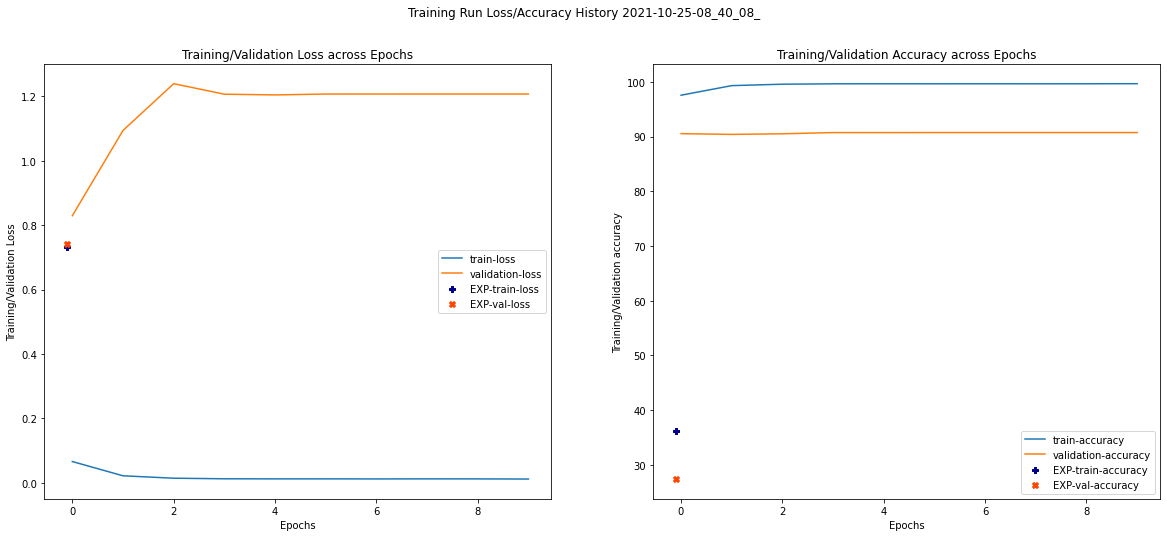

In [8]:
#training history plot for the run
plot_training_history(history_dict_pkl_path='/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-25-08_40_08_training_history.pkl')

In [9]:
#instantiate the model
print(f"loading model from: {pth_files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-25-08_40_08_model_epoch-7_val-acc-90.734.pth'))

loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-25-08_40_08_model_epoch-10_val-acc-90.734.pth


<All keys matched successfully>

In [10]:
#send the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

#### verify the accuracy acheived on the validation set (used during training)

data file "2019_val_awns_oversampled.csv" contains 157052 rows


[validation] Progress: 100%|██████████| 2454/2454 [1:08:22<00:00,  1.67s/it]


accuracy:  90.73


predictions:    157052
ground truths:  157052


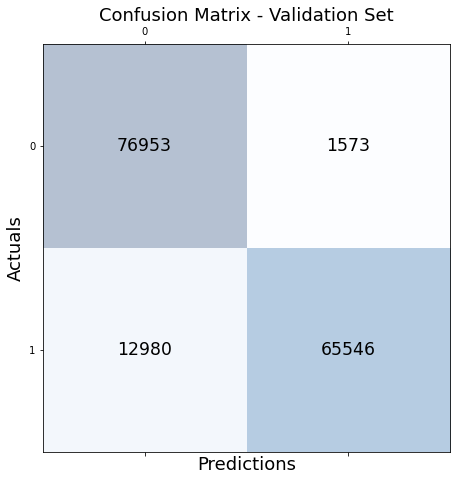

In [94]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'
batch_size = 64
title = 'Confusion Matrix - Validation Set'

#use helper fucntion
get_confusion_matrix_for_dataset(data_csv, batch_size, saved_model, title)

### Determine the accuracy on the test set (2019)

data file "2019_test_awns.csv" contains 39991 rows


[validation] Progress: 100%|██████████| 625/625 [05:44<00:00,  1.81it/s]

accuracy:  92.64


predictions:    39991
ground truths:  39991


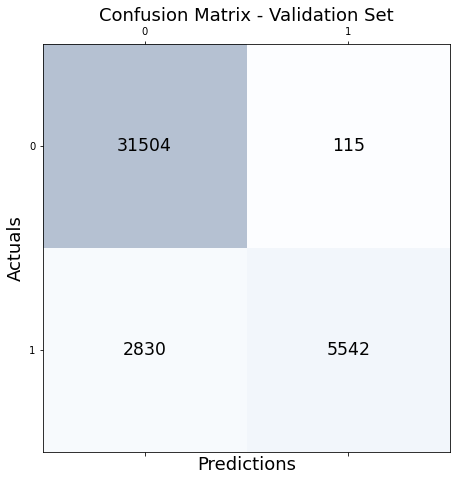

In [104]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'
batch_size = 64
title = 'Confusion Matrix - Test Set (2019)'

#use helper fucntion
get_confusion_matrix_for_dataset(data_csv, batch_size, saved_model, title)

## Determine the accuracy on the test set (2020)

data file "2020_test_awns.csv" contains 44163 rows


[validation] Progress: 100%|██████████| 691/691 [20:54<00:00,  1.82s/it]


accuracy:  67.42


predictions:    44163
ground truths:  44163


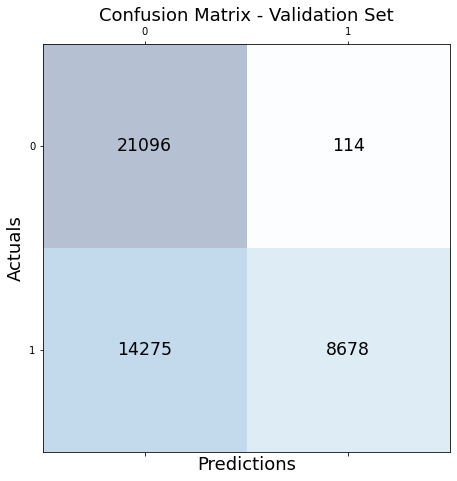

In [96]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2020_test_awns.csv'
batch_size = 64
title = 'Confusion Matrix - Test Set (2020)'

#use helper fucntion
get_confusion_matrix_for_dataset(data_csv, batch_size, saved_model, title)

### We are now going to inspect the images being passed to the model that are being missed
-we will use this as a preliminary step in understanding why the model is failing to generalize<br/>
-initial thoughts:  
* maybe they're bad pictures (blurry/mostly dirt/no seed-heads for the model to look at endedup in the crop)<br/>
* they could also be messed up when planting (awned plants ending up in awnless plots!)<br/>
* we won't know untill we visualize! 

In [62]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2020_test_awns.csv'
batch_size = 10
saved_model = saved_model
title = "Incorrect Predictions - (2020 test set)"
model_pth_name = '2021-10-25-08_40_08_model_epoch-7_val-acc-90.734.pth'

#first we'll experiment with how to do this, then we'll set it loose on the whole set
#////////////////////////////////////////////////////////////////////////////////////

#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'

transform = transforms.Compose([transforms.CenterCrop((224,224)), transforms.ToTensor()])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)



#set model mode
saved_model.eval()

imgs = []
predicted_label = []
groundtruth_label = []

b = 0 #breaker

#make sure to not accumulate gradients
with torch.no_grad():

    for images, labels, plot_ids in dataloader:
        
        if b==50:
            #print(f"breaking after {b}")
            break

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()
        
        #print("preds: ", list(preds.cpu().numpy()))
        #print("labels: ", list(labels.cpu().numpy()))

        
        for index, prediction in enumerate(preds):
            if prediction == labels[index]:
                continue
                #print("correct!")
                
            else:
                #print("false!")
                imgs.append(tensor_to_image(images[index]))
                predicted_label.append(prediction.detach().cpu().numpy())
                groundtruth_label.append(labels[index].detach().cpu().numpy())
                b+=1 #add to breaker when we've accumulated another false preditcion
                
            if b==50:
                #print(f"breaking after {b}")
                break




data file "2020_test_awns.csv" contains 44163 rows


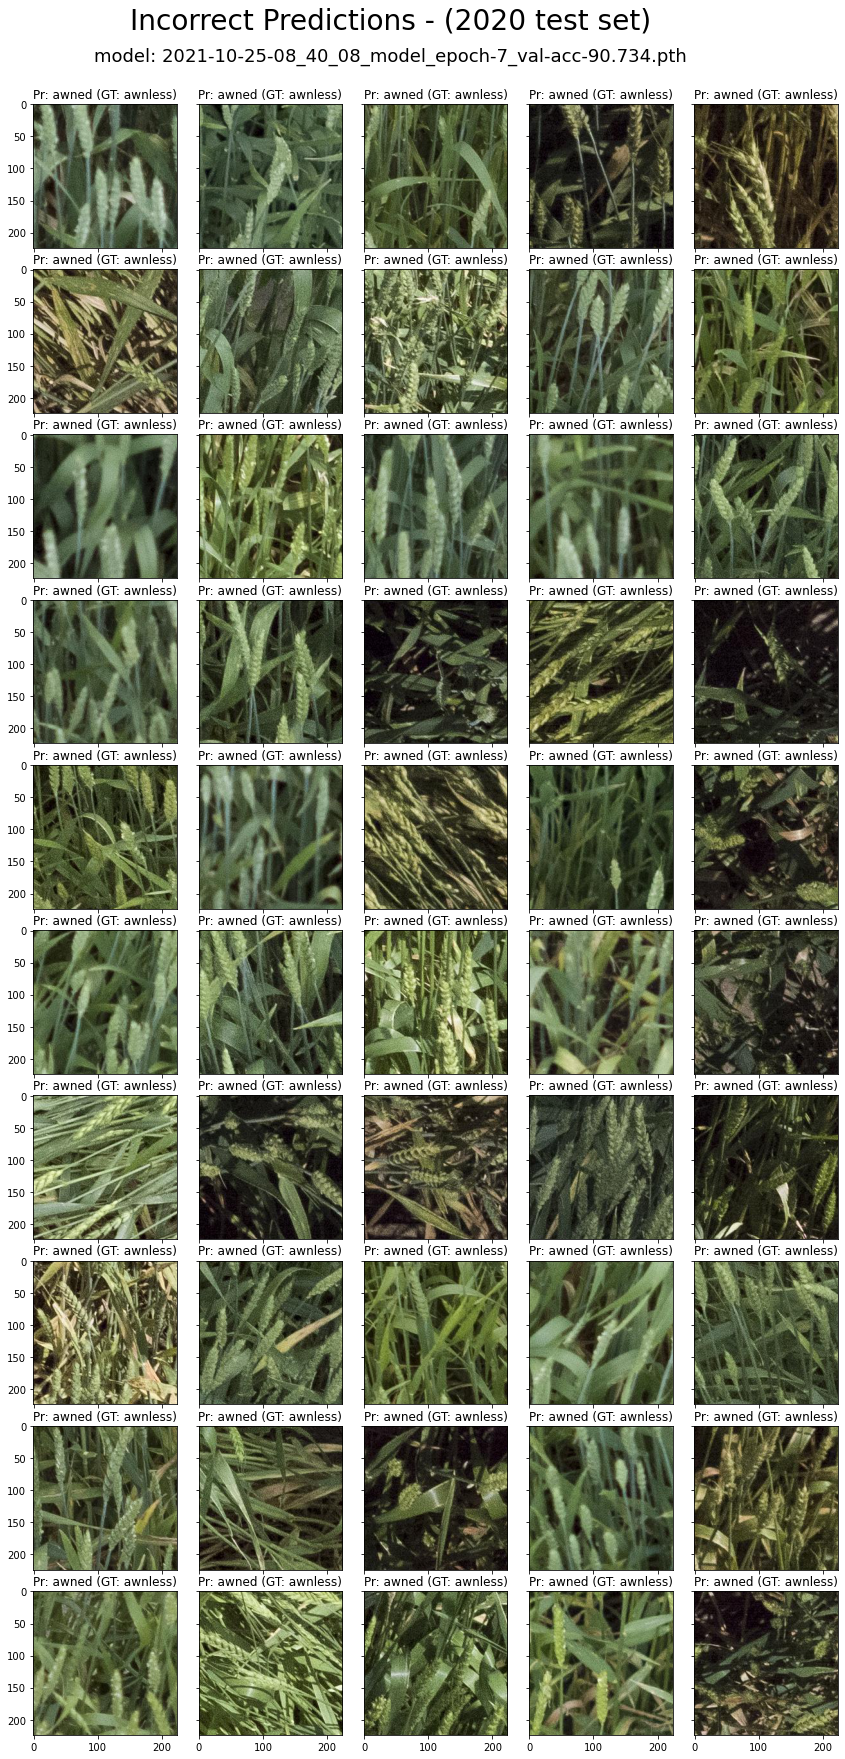

In [63]:
fig = plt.figure(figsize=(50., 30.))


grid = ImageGrid(fig, 
                 rect=111,  # similar to subplot(111)
                 nrows_ncols=(10, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, im, pred, grndth in zip(grid, imgs, predicted_label, groundtruth_label):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    
    ax.set_title("Pr: awned (GT: awnless)" if pred == 0 and grndth == 1  else "Pr: AWNLESS (GT: awned)")

#output
fig.text(x=0.5, y=0.915, s=title, fontsize=28, ha="center", transform=fig.transFigure)
fig.text(x=0.5, y=0.90, s=f"model: {model_pth_name}", fontsize=18, ha="center", transform=fig.transFigure)

plt.show()

In [ ]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2020_test_awns.csv'
batch_size = 10
saved_model = saved_model
title = "Incorrect Predictions - 2020 test-set"
save_prefix = "incorrects_2020_testset"


#first we'll experiment with how to do this, then we'll set it loose on the whole set
#////////////////////////////////////////////////////////////////////////////////////

#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'

transform = transforms.Compose([transforms.CenterCrop((224,224)), transforms.ToTensor()])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)



#set model mode
saved_model.eval()

imgs = []
predicted_label = []
groundtruth_label = []

b = 0 #breaker

#make sure to not accumulate gradients
with torch.no_grad():

    for images, labels, plot_ids in dataloader:
        
        if b==50:
            #print(f"breaking after {b}")
            break

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()
        
        #print("preds: ", list(preds.cpu().numpy()))
        #print("labels: ", list(labels.cpu().numpy()))

        
        for index, prediction in enumerate(preds):
            if prediction == labels[index]:
                continue
                #print("correct!")
                
            else:
                #print("false!")
                imgs.append(tensor_to_image(images[index]))
                predicted_label.append(prediction.detach().cpu().numpy())
                groundtruth_label.append(labels[index].detach().cpu().numpy())
                b+=1 #add to breaker when we've accumulated another false preditcion
                
            if b==50:
                #print(f"breaking after {b}")
                break
        

fig = plt.figure(figsize=(50., 30.))
fig.suptitle(title, y=0.91, fontsize=25)
grid = ImageGrid(fig, 
                 rect=111,  # similar to subplot(111)
                 nrows_ncols=(10, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, im, pred, grndth in zip(grid, imgs, predicted_label, groundtruth_label):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    
    ax.set_title("Pr: awned (GT: awnless)" if pred == 0 and grndth == 1  else "Pr: awnless (GT: awned)")

#output
save_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/montages"
fig.savefig(os.path.join(save_dir, f"{save_prefix}_{count_saves}.png

In [22]:
def tensor_to_image(tensor):
    '''helper function to take a tensor and image-ize it'''
    
    #take the tensor representation of the image and numpyify it
    image = tensor.clone().detach().cpu().numpy()
    
    #re order the dimensionality for matplotlib
    image = image.transpose(1, 2, 0)
    
    image = image.clip(0,1)
    
    return image

### model training: 2021-10-23
**lr** = 0.00001 (no scheduler)<br/>**batch_size** = 32<br/>**epochs** = 10<br/>**train dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv'<br/>**validation dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'<br/>**model state_dicts:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-23-16_47_15_model_epoch-2_val-acc-90.148.pth, 2021-10-23-16_47_15_model_epoch-3_val-acc-90.161.pth, 2021-10-23-16_47_15_model_epoch-4_val-acc-90.352.pth, 2021-10-23-16_47_15_model_epoch-5_val-acc-90.269.pth, 2021-10-23-16_47_15_model_epoch-6_val-acc-89.732.pth<br/>**Note:** no dataset normalization was used during training



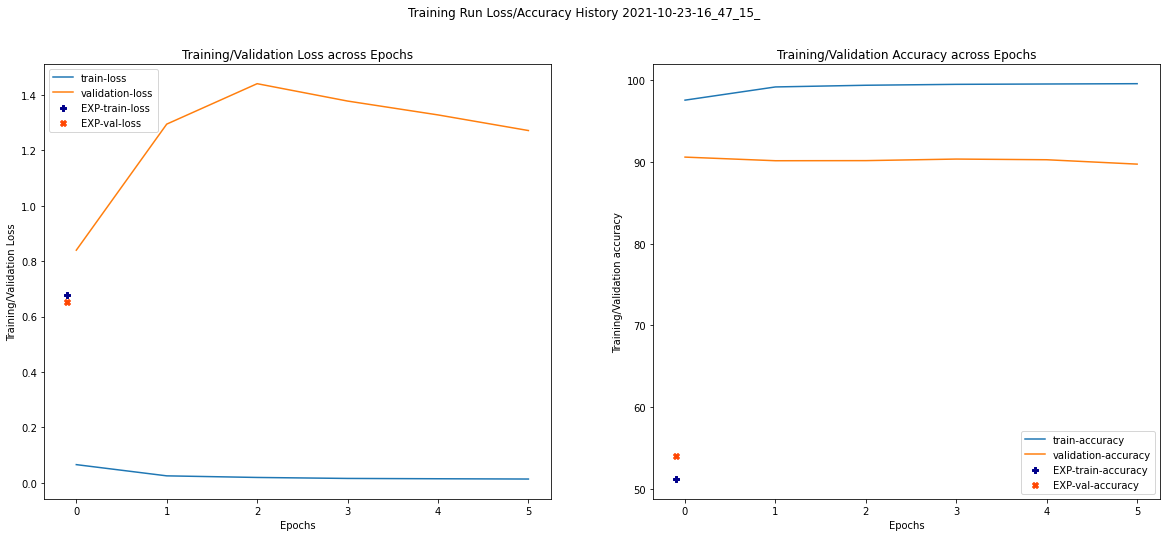

In [71]:
#training history plot for the run
plot_training_history(history_dict_pkl_path=pkl_files[-1])

In [72]:
#instantiate the model
print(f"loading model from: {pth_files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-23-16_47_15_model_epoch-4_val-acc-90.352.pth'))

loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-23-16_47_15_model_epoch-6_val-acc-89.732.pth


<All keys matched successfully>

In [73]:
#send the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

#### verify the accuracy acheived on the validation set (used during training)

In [74]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'
batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

data file "2019_val_awns_oversampled.csv" contains 157052 rows


In [75]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

# Get the predictions/GT's for the confusion matrix
predictions = []
ground_truths = []

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()
        
        ground_truths.extend(list(labels.cpu().numpy()))
        predictions.extend(list(preds.cpu().numpy()))

[validation] Progress: 100%|██████████| 2454/2454 [20:44<00:00,  1.97it/s]


In [76]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)
print('\n')
print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

accuracy:  90.35


predictions:    157052
ground truths:  157052


In [77]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

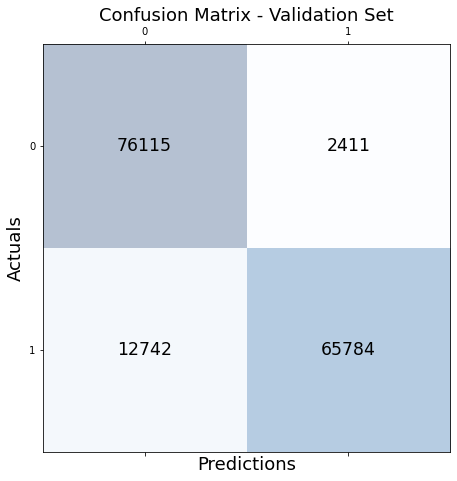

In [78]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Validation Set', fontsize=18)
plt.show()

### examine the accuracy on the test set (2019)

data file "2019_test_awns.csv" contains 39991 rows


[validation] Progress: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s]

accuracy:  95.70


predictions:    39991
ground truths:  39991


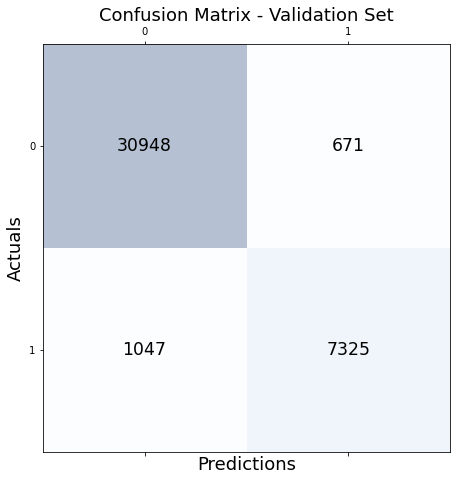

In [80]:
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'
batch_size = 64

#use helper fucntion
get_confusion_matrix_for_dataset(data_csv, batch_size, saved_model)

### model training: 2021-10-20
**lr** = 0.00001 (no scheduler)<br/>**batch_size** = 32<br/>**epochs** = 10<br/>**train dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv' (but actually imbalanced :P)<br/>**validation dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'<br/>**model state_dict:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-20-06_44_27_model_epoch-9.pth'


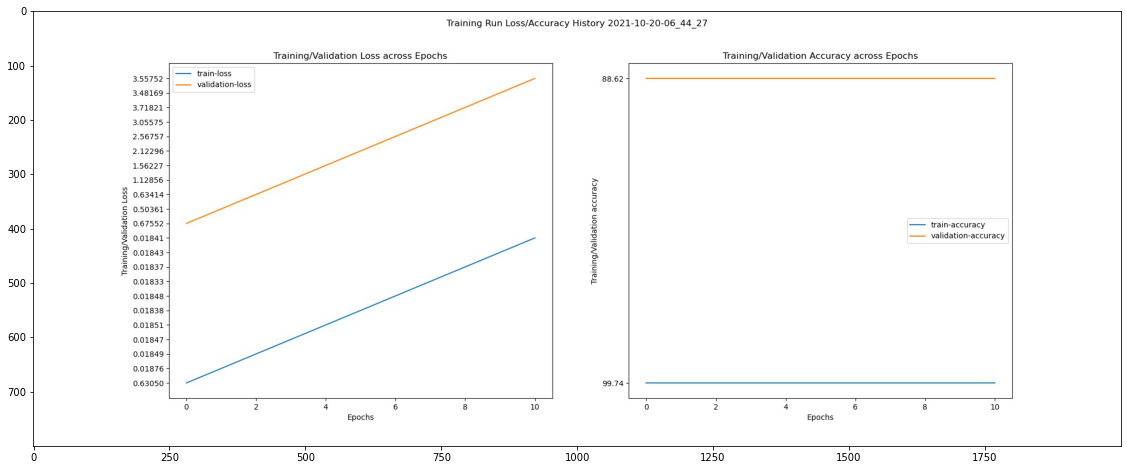

In [16]:
#training history plot for the run
plot_img = PIL.Image.open(plot_files[-1])
plt.figure(figsize = (20,8))
plt.imshow(plot_img)

In [47]:
#instantiate the model
print(f"loading model from: {pth_files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load(pth_files[-1]))

loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-21-17_52_20_model_epoch-5.pth


<All keys matched successfully>

In [38]:
#send the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

#### verify the accuracy acheived on the validation set (used during training)

In [ ]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [26]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()

[validation] Progress: 100%|██████████| 10858/10858 [14:35<00:00, 12.41it/s]


In [27]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)

accuracy:  88.62


In [40]:
# Get the predictions
predictions = []
ground_truths = []

progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

#set model mode
saved_model.eval()

for step, data in enumerate(progress_bar):
    
    #unpack the data from the progress bar
    images, labels = data[0], data[1]
    
    images = images.to(device)
    
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.cpu().numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

[test] Progress: 100%|██████████| 2715/2715 [11:48<00:00,  3.83it/s]

predictions:    86863
ground truths:  86863


In [41]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

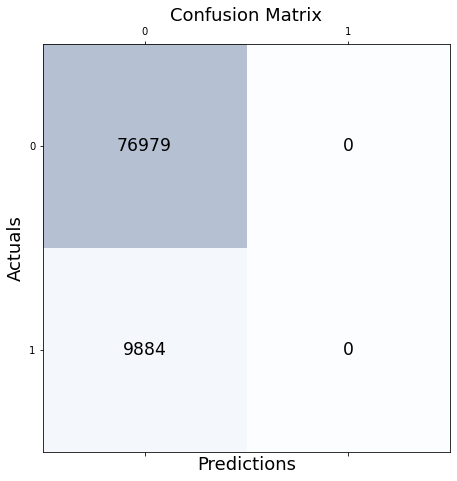

In [42]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#### determine the accuracy on the test set

In [29]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns.csv'
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [30]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()

[test] Progress: 100%|██████████| 1026/1026 [09:34<00:00,  1.79it/s]


In [31]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)

accuracy:  93.22


In [32]:
# Get the predictions
predictions = []
ground_truths = []

progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

#set model mode
saved_model.eval()

for step, data in enumerate(progress_bar):
    
    #unpack the data from the progress bar
    images, labels = data[0], data[1]
    
    images = images.to(device)
    
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.cpu().numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

[test] Progress: 100%|██████████| 1026/1026 [04:34<00:00,  3.74it/s]

predictions:    32809
ground truths:  32809


In [33]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

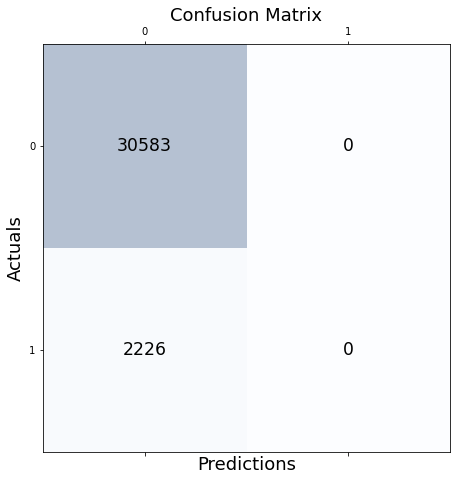

In [34]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### model training: 2021-10-21
**lr** = 0.00001 (no scheduler)<br/>**batch_size** = 32<br/>**epochs** = 10 (but stoped at epoch 6)<br/>**train dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv' (this time actually balanced)<br/>**validation dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'<br/>**model state_dict:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-21-17_52_20_model_epoch-5.pth'<br/>**Note:** no normalization was used during this training

In [48]:
#instantiate the model
print(f"loading model from: {pth_files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-21-17_52_20_model_epoch-5.pth'))


loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-21-17_52_20_model_epoch-5.pth


<All keys matched successfully>

In [49]:
#send the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)
print("model to: ", device)

model to:  cuda:0


#### first verify the accuracy acheived on the validation set (during training)
-this is unfortunatley lower than the maximum axxuracy on the validation set because I was only saving every 5 epochs and it peaked around epoch 3 as far as I remmeber

In [50]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_oversampled.csv'
batch_size = 32

transform = transforms.Compose([transforms.ToTensor()])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

data file "2019_val_awns_oversampled.csv" contains 157052 rows


In [51]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

# Get the predictions/GT's for the confusion matrix
predictions = []
ground_truths = []

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()
        
        ground_truths.extend(list(labels.cpu().numpy()))
        predictions.extend(list(preds.cpu().numpy()))

[validation] Progress: 100%|██████████| 4908/4908 [1:43:56<00:00,  1.27s/it]


In [52]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)
print('\n')
print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

accuracy:  89.54


predictions:    157052
ground truths:  157052


In [53]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

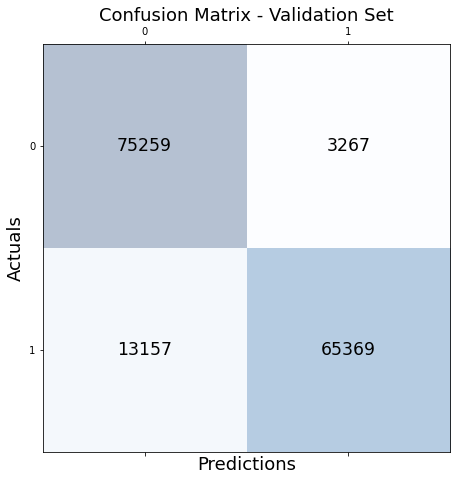

In [54]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Validation Set', fontsize=18)
plt.show()

In [6]:
a =99.109201273128301298

In [19]:
print(f"a= {a:.3f}")

a= 99.109


Factor =  0.95  , Learning Rate =  0.0001
Factor =  0.95  , Learning Rate =  5.500000000000001e-05
Factor =  0.95  , Learning Rate =  1.6637500000000005e-05
Factor =  0.95  , Learning Rate =  2.7680640625000015e-06
Factor =  0.95  , Learning Rate =  2.5329516211914085e-07
Factor =  0.95  , Learning Rate =  1.2747949735765553e-08
Factor =  0.95  , Learning Rate =  3.5287141534129016e-10
Factor =  0.95  , Learning Rate =  5.372238759193554e-12
Factor =  0.95  , Learning Rate =  4.4983870659592173e-14
Factor =  0.95  , Learning Rate =  2.0716721475396112e-16


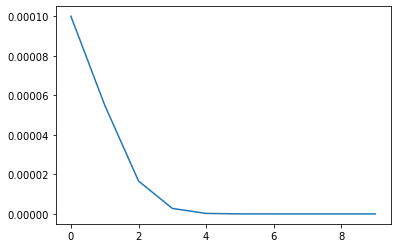

In [83]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
lmbda = lambda epoch: 0.55 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    print("Factor = ",0.55," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(10),lrs)